In [1]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,explained_variance_score
import time
from datetime import timedelta
import math
import pickle
import pandas
from datapipe import bin_ndarray
from skimage import io

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Input, Dense, Flatten, GlobalAveragePooling2D, Conv1D,Conv2D, MaxPooling2D,MaxPooling1D, Dropout, UpSampling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [12]:
ear = io.imread('./data/ear_AV2.tif')
np.random.seed(42)
(length, lenx, leny) = ear.shape
print(ear.shape)
print(lenx,leny)

(53232, 247, 255)
247 255


In [13]:
#though I was going to do multiple in this file but maybe if I have multiple 
data = ear

In [20]:
def cropImage(imArr):
    (length, x, y, channel) = imArr.shape
    cropped = np.zeros((length, x+1, y+1, channel))
    for ind, im in enumerate(imArr):
        for rowind, row in enumerate(im):
            if rowind >= 5:
                row1 = np.append(row,0)
                cropped[ind][rowind-5] = row1.reshape(y+1,1)
    return cropped
            
    

In [21]:
num_data = len(data)
train_split = 0.8
num_train = int(train_split*num_data)
num_test = num_data - num_train
x_train = data[0:num_train].reshape(num_train, (lenx*leny))
x_test = data[(num_train):].reshape(num_test, (lenx*leny))

In [22]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [23]:
x_test_scaled = x_scaler.transform(x_test)

In [28]:
input_img = Input(shape=(lenx+1, leny+1, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (2, 2), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 3), padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(16, (2, 2), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
# x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 3))(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (2, 2), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [29]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 248, 256, 1)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 248, 256, 64)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 124, 128, 64)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 124, 128, 32)      8224      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 64, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 62, 64, 16)        2064      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 32, 16)        0         
__________

In [30]:
print(lenx,leny)
x_train = np.ndarray.astype(x_train_scaled.reshape((num_train, lenx,leny,1)), np.float16)
x_test = np.ndarray.astype(x_test_scaled.reshape((num_test, lenx, leny, 1)), np.float16)
print("converted")
x_train = cropImage(x_train)
x_test = cropImage(x_test)
print(x_test.shape)

247 255
converted
(10647, 248, 256, 1)


In [31]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [32]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [33]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [34]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [35]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]
print(x_train.shape)

(42585, 248, 256, 1)


In [36]:
%%time
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=62,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)

Train on 42585 samples, validate on 10647 samples
Epoch 1/25
42585/42585 [==============================] - 640s 15ms/step - loss: 0.4547 - val_loss: 0.4279

Epoch 00001: val_loss improved from inf to 0.42789, saving model to 23_checkpoint.keras
Epoch 2/25
42585/42585 [==============================] - 635s 15ms/step - loss: 0.4287 - val_loss: 0.4172

Epoch 00002: val_loss improved from 0.42789 to 0.41717, saving model to 23_checkpoint.keras
Epoch 3/25
42585/42585 [==============================] - 636s 15ms/step - loss: 0.4202 - val_loss: 0.4132

Epoch 00003: val_loss improved from 0.41717 to 0.41319, saving model to 23_checkpoint.keras
Epoch 4/25
42585/42585 [==============================] - 634s 15ms/step - loss: 0.4156 - val_loss: 0.4095

Epoch 00004: val_loss improved from 0.41319 to 0.40948, saving model to 23_checkpoint.keras
Epoch 5/25
42585/42585 [==============================] - 634s 15ms/step - loss: 0.4133 - val_loss: 0.4080

Epoch 00005: val_loss improved from 0.40948 to

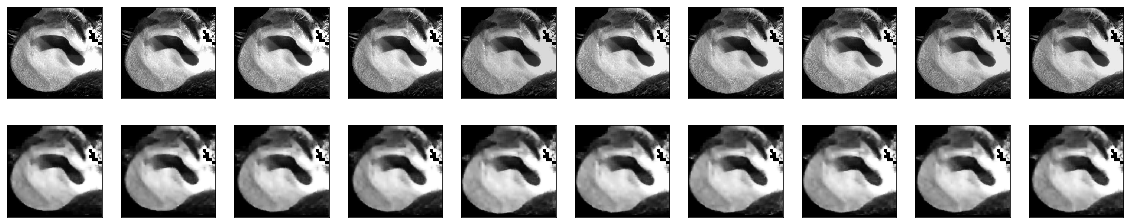

In [38]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[(i*100+20)].reshape(lenx+1, leny+1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[(i*100+20)].reshape(lenx+1, leny+1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [39]:
autoencoder.save('earEncoder2.h5')